# Without Filter

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
    
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# -------------------------
# Hyperparameters
# -------------------------
ENV_NAME = "Pendulum-v1"
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64
MEMORY_SIZE = 10_000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 500
TARGET_UPDATE = 50
NUM_EPISODES = 1000

device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


In [3]:
class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device),
        )

    def __len__(self):
        return len(self.buffer)


In [4]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, act_dim)
        self.log_std = nn.Linear(256, act_dim)

    def forward(self, state):
        x = self.net(state)
        mu = self.mu(x)
        log_std = torch.clamp(self.log_std(x), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, state):
        mu, std = self(state)
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()
        action = torch.tanh(z)

        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob


In [5]:
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))


In [6]:
env = gym.make("Pendulum-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

actor = Actor(obs_dim, act_dim).to(device)
critic1 = Critic(obs_dim, act_dim).to(device)
critic2 = Critic(obs_dim, act_dim).to(device)
target1 = Critic(obs_dim, act_dim).to(device)
target2 = Critic(obs_dim, act_dim).to(device)

target1.load_state_dict(critic1.state_dict())
target2.load_state_dict(critic2.state_dict())

actor_optim = optim.Adam(actor.parameters(), lr=3e-4)
critic_optim = optim.Adam(
    list(critic1.parameters()) + list(critic2.parameters()), lr=3e-4
)

alpha = 0.2
gamma = 0.99
tau = 0.005

buffer = ReplayBuffer()

In [7]:
print(env.unwrapped.__doc__)



    ## Description

    The inverted pendulum swingup problem is based on the classic problem in control theory.
    The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
    The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
    into an upright position, with its center of gravity right above the fixed point.

    The diagram below specifies the coordinate system used for the implementation of the pendulum's
    dynamic equations.

    ![Pendulum Coordinate System](/_static/diagrams/pendulum.png)

    - `x-y`: cartesian coordinates of the pendulum's end in meters.
    - `theta` : angle in radians.
    - `tau`: torque in `N m`. Defined as positive _counter-clockwise_.

    ## Action Space

    The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | Torque | -2.

In [8]:
state, _ = env.reset()
episode_rewards_no_hpf = []
current_episode_reward = 0

for step in range(30_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    current_episode_reward += reward
    
    buffer.push(state, action, reward, next_state, done)
    state = next_state
    
    if done:
        episode_rewards_no_hpf.append(current_episode_reward)
        current_episode_reward = 0
        state, _ = env.reset()

    if len(buffer) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer.sample(256)

    # ----- Critic update -----
    with torch.no_grad():
        next_actions, logp = actor.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1(next_states, next_actions)
        q2_t = target2(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (torch.min(q1_t, q2_t) - alpha * logp)

    q1 = critic1(states, actions)
    q2 = critic2(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    # ----- Actor update -----
    actions_new, logp = actor.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1(states, actions_new)
    q2_new = critic2(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    # ----- Target update -----
    for t, s in zip(target1.parameters(), critic1.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2.parameters(), critic2.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    if step % 5000 == 0:
        print(f"Step {step}")

Step 5000
Step 10000
Step 15000
Step 20000
Step 25000


In [10]:
env = gym.make("Pendulum-v1", render_mode="human")
state, _ = env.reset(seed=42)
done = False
state_vars = []

while not done:
    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = actor.sample(s)
        action = (action * act_limit).cpu().numpy()[0]

    state, _, terminated, truncated, _ = env.step(action)
    state_vars.append(state)
    done = terminated or truncated

env.close()


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Convert collected states to array
state_vars_filtered = np.array(state_vars)

# Extract variables
cos_theta_filtered = state_vars_filtered[:, 0] # x-coordinate
sin_theta_filtered = state_vars_filtered[:, 1] # y-coordinate
theta_dot_filtered = state_vars_filtered[:, 2] # angular velocity

# Recover angle theta
theta = np.arctan2(sin_theta_filtered, cos_theta_filtered)

# Sampling parameters
dt = env.unwrapped.dt          # timestepS (0.05 s)
N = len(theta)

# FFT
theta_fft = np.fft.fft(theta)
theta_dot_fft = np.fft.fft(theta_dot_filtered)
freqs = np.fft.fftfreq(N, d=dt)


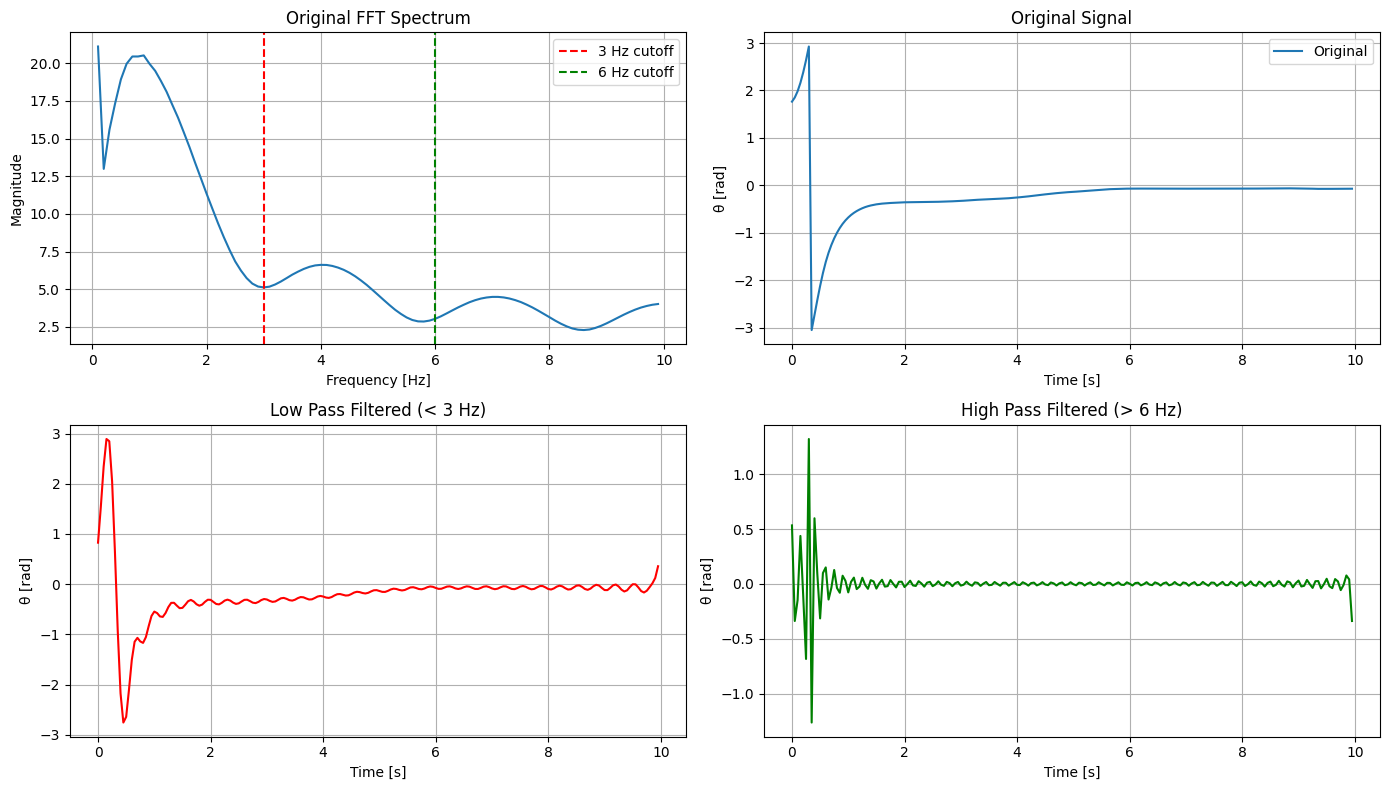

In [19]:
lpf = 3
hpf = 6

# Apply low pass filter at 3 Hz
theta_fft_lowpass = theta_fft.copy()
theta_fft_lowpass[np.abs(freqs) > lpf] = 0
theta_lowpass = np.fft.ifft(theta_fft_lowpass).real

# Apply high pass filter at 6 Hz
theta_fft_highpass = theta_fft.copy()
theta_fft_highpass[np.abs(freqs) < hpf] = 0
theta_highpass = np.fft.ifft(theta_fft_highpass).real

# Use only positive frequencies for plotting
mask = freqs > 0

# Plot FFT magnitude and filtered signals
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original FFT
axes[0, 0].plot(freqs[mask], np.abs(theta_fft[mask]))
axes[0, 0].axvline(lpf, color='r', linestyle='--', label=f'{lpf} Hz cutoff')
axes[0, 0].axvline(hpf, color='g', linestyle='--', label=f'{hpf} Hz cutoff')
axes[0, 0].set_xlabel("Frequency [Hz]")
axes[0, 0].set_ylabel("Magnitude")
axes[0, 0].set_title("Original FFT Spectrum")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Original signal
time = np.arange(N) * dt
axes[0, 1].plot(time, theta, label='Original')
axes[0, 1].set_xlabel("Time [s]")
axes[0, 1].set_ylabel("θ [rad]")
axes[0, 1].set_title("Original Signal")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Low pass filtered
axes[1, 0].plot(time, theta_lowpass, color='red')
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("θ [rad]")
axes[1, 0].set_title(f"Low Pass Filtered (< {lpf} Hz)")
axes[1, 0].grid(True)

# High pass filtered
axes[1, 1].plot(time, theta_highpass, color='green')
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("θ [rad]")
axes[1, 1].set_title(f"High Pass Filtered (> {hpf} Hz)")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [20]:
# Energy = sum of squared magnitudes

# Band 1: 0 to  lpf Hz
mask_band1 = np.abs(freqs) <= lpf
energy_band1 = np.sum(np.abs(theta_fft[mask_band1])**2)

# Band 2: lpf to hpf Hz
mask_band2 = (np.abs(freqs) > lpf) & (np.abs(freqs) <= hpf)
energy_band2 = np.sum(np.abs(theta_fft[mask_band2])**2)

# Band 3: hpf Hz and above
mask_band3 = np.abs(freqs) > hpf    
energy_band3 = np.sum(np.abs(theta_fft[mask_band3])**2)

# Total energy
total_energy = energy_band1 + energy_band2 + energy_band3

print(f"Energy Distribution:")
print(f"  Band 1 (0-{lpf} Hz):   {energy_band1:.2f} ({100*energy_band1/total_energy:.1f}%)")
print(f"  Band 2 ({lpf}-{hpf} Hz):   {energy_band2:.2f} ({100*energy_band2/total_energy:.1f}%)")
print(f"  Band 3 (>{hpf} Hz):    {energy_band3:.2f} ({100*energy_band3/total_energy:.1f}%)")
print(f"  Total:             {total_energy:.2f}")



Energy Distribution:
  Band 1 (0-3 Hz):   14738.74 (84.7%)
  Band 2 (3-6 Hz):   1636.91 (9.4%)
  Band 3 (>6 Hz):    1016.81 (5.8%)
  Total:             17392.46


In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print(sigmoid(energy_band1/total_energy))
print(sigmoid(energy_band2/total_energy))
print(sigmoid(energy_band3/total_energy))

0.700026
0.5235116
0.5146115


# With Filter

In [22]:
class LPFRewardWrapper(gym.Wrapper):
    def __init__(self, env, alpha=0.4, beta=0.99, lam=1.0):
        """
        alpha : LPF coefficient (smaller = higher cutoff)
        beta  : energy smoothing
        lam   : HF penalty strength
        """
        super().__init__(env)
        self.alpha = alpha
        self.beta = beta
        self.lam = lam

        self.prev_y = 0.0
        self.energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_y = 0.0
        self.energy = 0.0
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # ----- Low-pass filter torque -----
        x = action[0]
        y = (1 - self.alpha) * x + self.alpha * self.prev_y
        self.prev_y = y

        # ----- High-frequency residual -----
        hf = x - y

        # ----- Energy estimate -----
        self.energy = self.beta * self.energy + (1 - self.beta) * (hf ** 2)

        reward -= self.lam * self.energy
        info["hf_energy"] = self.energy

        return obs, reward, terminated, truncated, info


In [23]:
env = LPFRewardWrapper(
    gym.make("Pendulum-v1"),
    alpha=0.38,
    beta=0.99,
    lam=10.0
)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]


In [24]:
actor = Actor(obs_dim, act_dim).to(device)
critic1 = Critic(obs_dim, act_dim).to(device)
critic2 = Critic(obs_dim, act_dim).to(device)
target1 = Critic(obs_dim, act_dim).to(device)
target2 = Critic(obs_dim, act_dim).to(device)

target1.load_state_dict(critic1.state_dict())
target2.load_state_dict(critic2.state_dict())

actor_optim = optim.Adam(actor.parameters(), lr=3e-4)
critic_optim = optim.Adam(
    list(critic1.parameters()) + list(critic2.parameters()), lr=3e-4
)

buffer = ReplayBuffer()

gamma = 0.99
tau = 0.005
alpha_entropy = 0.2
batch_size = 256


In [25]:
state, _ = env.reset()
episode_rewards_with_hpf = []
current_episode_reward = 0
hf_energies = []

for step in range(30_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    current_episode_reward += reward
    hf_energies.append(info.get('hf_energy', 0.0))

    buffer.push(state, action, reward, next_state, done)
    state = next_state
    
    if done:
        episode_rewards_with_hpf.append(current_episode_reward)
        current_episode_reward = 0
        state, _ = env.reset()

    if len(buffer) < batch_size:
        continue

    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = (
        states.to(device),
        actions.to(device),
        rewards.to(device),
        next_states.to(device),
        dones.to(device),
    )

    # ----- Critic update -----
    with torch.no_grad():
        next_actions, logp = actor.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1(next_states, next_actions)
        q2_t = target2(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (
            torch.min(q1_t, q2_t) - alpha_entropy * logp
        )

    q1 = critic1(states, actions)
    q2 = critic2(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    # ----- Actor update -----
    actions_new, logp = actor.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1(states, actions_new)
    q2_new = critic2(states, actions_new)
    actor_loss = (alpha_entropy * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    # ----- Target update -----
    for t, s in zip(target1.parameters(), critic1.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2.parameters(), critic2.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    if step % 5000 == 0:
        print(f"Step {step}, HF energy {info.get('hf_energy', 0.0):.4f}")

Step 5000, HF energy 0.0033
Step 10000, HF energy 0.0047
Step 15000, HF energy 0.0044
Step 20000, HF energy 0.0015
Step 25000, HF energy 0.0014


In [26]:
env = gym.make("Pendulum-v1", render_mode="human")
state, _ = env.reset(seed=42)
done = False
state_vars = []

while not done:
    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = actor.sample(s)
        action = (action * act_limit).cpu().numpy()[0]

    state, _, terminated, truncated, _ = env.step(action)
    state_vars.append(state)
    done = terminated or truncated

env.close()


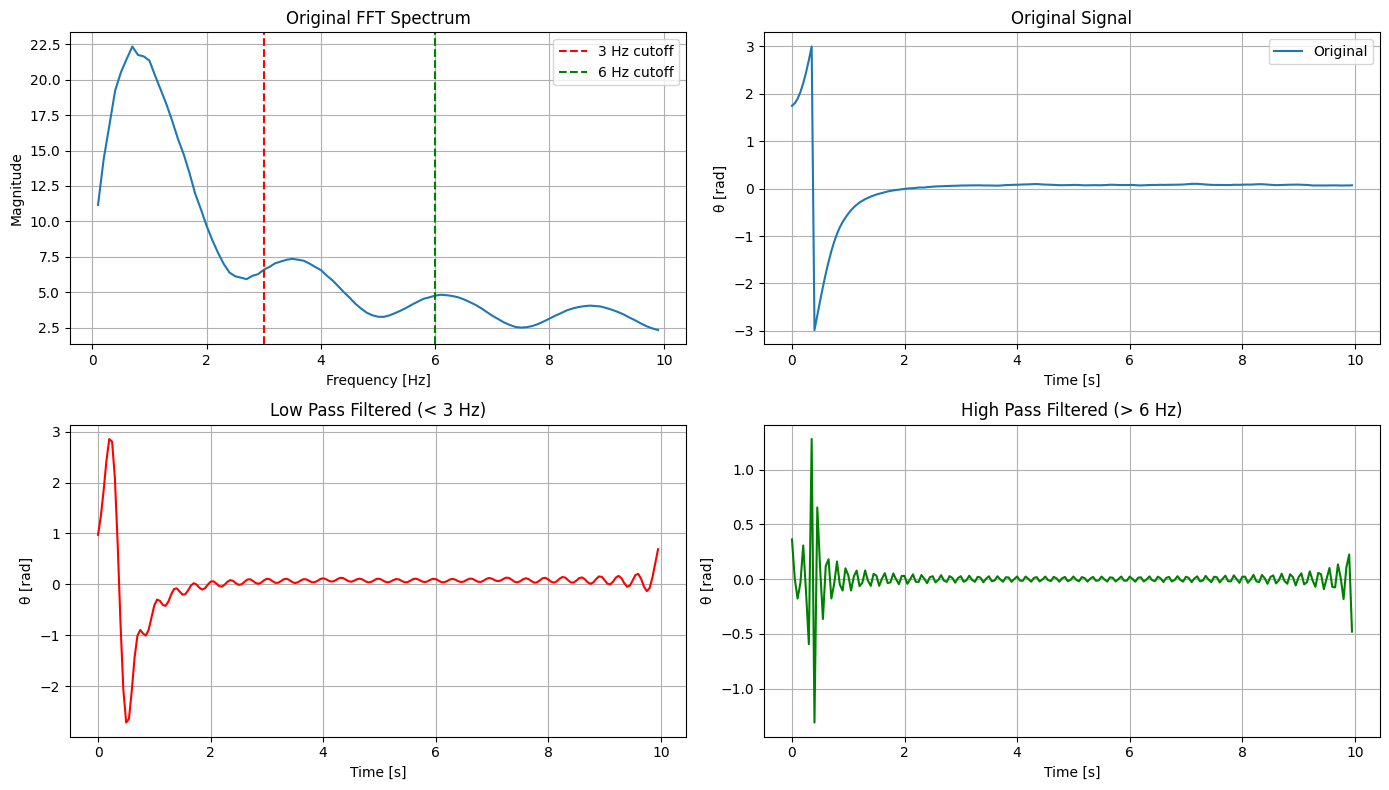

In [27]:
# First, need to analyze the collected state_vars for the filtered case
import numpy as np
import matplotlib.pyplot as plt

# Convert collected states to array
state_vars_filtered = np.array(state_vars)

# Extract variables
cos_theta_filtered = state_vars_filtered[:, 0] # x-coordinate
sin_theta_filtered = state_vars_filtered[:, 1] # y-coordinate
theta_dot_filtered = state_vars_filtered[:, 2] # angular velocity

# Recover angle theta
theta_filtered = np.arctan2(sin_theta_filtered, cos_theta_filtered)

# Sampling parameters
dt_filtered = env.unwrapped.dt          # timestepS (0.05 s)
N_filtered = len(theta_filtered)

# FFT
theta_fft_filtered = np.fft.fft(theta_filtered)
theta_dot_fft_filtered = np.fft.fft(theta_dot_filtered)
freqs_filtered = np.fft.fftfreq(N_filtered, d=dt_filtered)

lpf_filtered = 3
hpf_filtered = 6

# Apply low pass filter at 3 Hz
theta_fft_lowpass_filtered = theta_fft_filtered.copy()
theta_fft_lowpass_filtered[np.abs(freqs_filtered) > lpf_filtered] = 0
theta_lowpass_filtered = np.fft.ifft(theta_fft_lowpass_filtered).real

# Apply high pass filter at 6 Hz
theta_fft_highpass_filtered = theta_fft_filtered.copy()
theta_fft_highpass_filtered[np.abs(freqs_filtered) < hpf_filtered] = 0
theta_highpass_filtered = np.fft.ifft(theta_fft_highpass_filtered).real

# Use only positive frequencies for plotting
mask_filtered = freqs_filtered > 0

# Plot FFT magnitude and filtered signals
fig_filtered, axes_filtered = plt.subplots(2, 2, figsize=(14, 8))

# Original FFT
axes_filtered[0, 0].plot(freqs_filtered[mask_filtered], np.abs(theta_fft_filtered[mask_filtered]))
axes_filtered[0, 0].axvline(lpf_filtered, color='r', linestyle='--', label=f'{lpf_filtered} Hz cutoff')
axes_filtered[0, 0].axvline(hpf_filtered, color='g', linestyle='--', label=f'{hpf_filtered} Hz cutoff')
axes_filtered[0, 0].set_xlabel("Frequency [Hz]")
axes_filtered[0, 0].set_ylabel("Magnitude")
axes_filtered[0, 0].set_title("Original FFT Spectrum")
axes_filtered[0, 0].legend()
axes_filtered[0, 0].grid(True)

# Original signal
time_filtered = np.arange(N_filtered) * dt_filtered
axes_filtered[0, 1].plot(time_filtered, theta_filtered, label='Original')
axes_filtered[0, 1].set_xlabel("Time [s]")
axes_filtered[0, 1].set_ylabel("θ [rad]")
axes_filtered[0, 1].set_title("Original Signal")
axes_filtered[0, 1].legend()
axes_filtered[0, 1].grid(True)

# Low pass filtered
axes_filtered[1, 0].plot(time_filtered, theta_lowpass_filtered, color='red')
axes_filtered[1, 0].set_xlabel("Time [s]")
axes_filtered[1, 0].set_ylabel("θ [rad]")
axes_filtered[1, 0].set_title(f"Low Pass Filtered (< {lpf_filtered} Hz)")
axes_filtered[1, 0].grid(True)

# High pass filtered
axes_filtered[1, 1].plot(time_filtered, theta_highpass_filtered, color='green')
axes_filtered[1, 1].set_xlabel("Time [s]")
axes_filtered[1, 1].set_ylabel("θ [rad]")
axes_filtered[1, 1].set_title(f"High Pass Filtered (> {hpf_filtered} Hz)")
axes_filtered[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Energy = sum of squared magnitudes

# Band 1: 0 to  lpf_filtered Hz
mask_band1_filtered = np.abs(freqs_filtered) <= lpf_filtered
energy_band1_filtered = np.sum(np.abs(theta_fft_filtered[mask_band1_filtered])**2)

# Band 2: lpf_filtered to hpf_filtered Hz
mask_band2_filtered = (np.abs(freqs_filtered) > lpf_filtered) & (np.abs(freqs_filtered) <= hpf_filtered)
energy_band2_filtered = np.sum(np.abs(theta_fft_filtered[mask_band2_filtered])**2)

# Band 3: hpf_filtered Hz and above
mask_band3_filtered = np.abs(freqs_filtered) > hpf_filtered    
energy_band3_filtered = np.sum(np.abs(theta_fft_filtered[mask_band3_filtered])**2)

# Total energy
total_energy_filtered = energy_band1_filtered + energy_band2_filtered + energy_band3_filtered

print(f"Energy Distribution:")
print(f"  Band 1 (0-{lpf_filtered} Hz):   {energy_band1_filtered:.2f} ({100*energy_band1_filtered/total_energy_filtered:.1f}%)")
print(f"  Band 2 ({lpf_filtered}-{hpf_filtered} Hz):   {energy_band2_filtered:.2f} ({100*energy_band2_filtered/total_energy_filtered:.1f}%)")
print(f"  Band 3 (>{hpf_filtered} Hz):    {energy_band3_filtered:.2f} ({100*energy_band3_filtered/total_energy_filtered:.1f}%)")
print(f"  Total:             {total_energy_filtered:.2f}")

Energy Distribution:
  Band 1 (0-3 Hz):   13301.13 (82.9%)
  Band 2 (3-6 Hz):   1757.62 (10.9%)
  Band 3 (>6 Hz):    994.61 (6.2%)
  Total:             16053.37


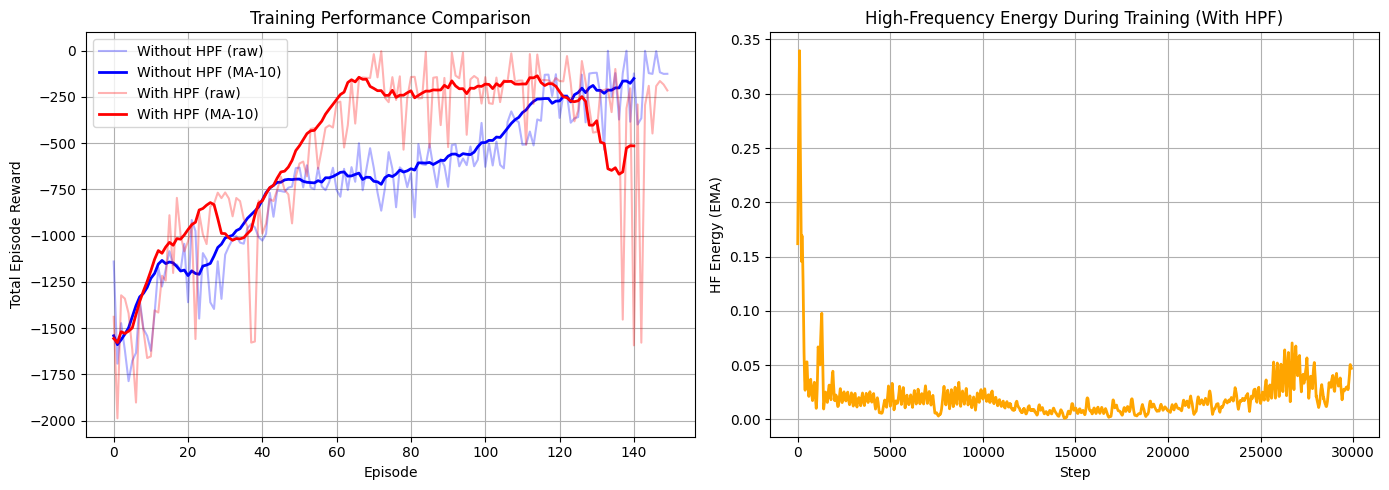


Without HPF:
  Episodes: 150
  Mean reward (last 50): -294.01
  Std reward (last 50): 180.59

With HPF:
  Episodes: 150
  Mean reward (last 50): -295.61
  Std reward (last 50): 333.78
  Mean HF energy: 0.020729


In [29]:
# Plot reward comparison between training runs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute moving average for smoother visualization
def moving_average(data, window=10):
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Plot 1: Episode rewards comparison
axes[0].plot(episode_rewards_no_hpf, alpha=0.3, color='blue', label='Without HPF (raw)')
axes[0].plot(moving_average(episode_rewards_no_hpf, 10), color='blue', linewidth=2, label='Without HPF (MA-10)')
axes[0].plot(episode_rewards_with_hpf, alpha=0.3, color='red', label='With HPF (raw)')
axes[0].plot(moving_average(episode_rewards_with_hpf, 10), color='red', linewidth=2, label='With HPF (MA-10)')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Episode Reward')
axes[0].set_title('Training Performance Comparison')
axes[0].legend()
axes[0].grid(True)

# Plot 2: High-frequency energy over time
axes[1].plot(moving_average(hf_energies, 100), color='orange', linewidth=2)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('HF Energy (EMA)')
axes[1].set_title('High-Frequency Energy During Training (With HPF)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nWithout HPF:")
print(f"  Episodes: {len(episode_rewards_no_hpf)}")
print(f"  Mean reward (last 50): {np.mean(episode_rewards_no_hpf[-50:]):.2f}")
print(f"  Std reward (last 50): {np.std(episode_rewards_no_hpf[-50:]):.2f}")

print(f"\nWith HPF:")
print(f"  Episodes: {len(episode_rewards_with_hpf)}")
print(f"  Mean reward (last 50): {np.mean(episode_rewards_with_hpf[-50:]):.2f}")
print(f"  Std reward (last 50): {np.std(episode_rewards_with_hpf[-50:]):.2f}")
print(f"  Mean HF energy: {np.mean(hf_energies):.6f}")
